<a href="https://colab.research.google.com/github/ZILPHA-KR/Data_analysis_using_python/blob/main/vgg16%2Bsvm%2Bbayesian%2Bsmote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import shap
import albumentations as A
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [ ]:
# Load and preprocess image data from directory (only Circle task)
def load_images_from_directory(base_dir, img_size=(224, 224)):
    X_images = []
    y_labels = []

    class_names = {
        'Healthy': 0,
        'Patient': 1
    }

    for health_status in class_names:
        task_dir = os.path.join(base_dir, f'{health_status} Circle')
        if os.path.exists(task_dir):
            for img_name in os.listdir(task_dir):
                img_path = os.path.join(task_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    X_images.append(img)
                    y_labels.append(class_names[health_status])

    X_images = np.array(X_images)
    y_labels = np.array(y_labels)

    return X_images, y_labels


In [ ]:
# Data augmentation with Albumentations
def augment_data(X_images, y_labels):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.CoarseDropout(p=0.5),
        A.Blur(blur_limit=3, p=0.3)
    ])

    X_augmented = []
    y_augmented = []

    for img, label in zip(X_images, y_labels):
        augmented = aug(image=img)
        X_augmented.append(augmented['image'])
        y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)


In [ ]:
# Load and preprocess data
base_dir = '/content/drive/MyDrive/Spiral_data'
X_images, y_labels = load_images_from_directory(base_dir)

In [ ]:
# Augment data
X_augmented, y_augmented = augment_data(X_images, y_labels)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_augmented)

In [ ]:
# Extract features using ResNet50
def extract_features(X_images):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    feature_extractor = Model(inputs=base_model.input, outputs=x)

    X_features = feature_extractor.predict(X_images)
    X_features = X_features.reshape(X_features.shape[0], -1)
    return X_features

X_image_features = extract_features(X_augmented)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step


In [ ]:
# Handle data imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_image_features, y_encoded)


In [ ]:
# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)


In [ ]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Define the parameter grid for Bayesian Optimization
param_space = {
    'C': Real(1e-3, 1e3, prior='log-uniform'),
    'gamma': Real(1e-4, 1e-1, prior='log-uniform'),
    'kernel': ['rbf', 'linear'],
    'degree': Integer(2, 5)
}

In [ ]:
# Train model using SVM with Bayesian Optimization
def create_model(X_train, y_train):
    svm_model = SVC(probability=True, random_state=42, class_weight=class_weights_dict)
    bayes_search = BayesSearchCV(svm_model, search_spaces=param_space, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
    bayes_search.fit(X_train, y_train)
    return bayes_search.best_estimator_

best_model = create_model(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
# Evaluate the model on the validation set
y_val_pred = best_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Validation AUC-ROC Score:", roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1]))

Validation Accuracy: 0.9333333333333333
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.83      1.00      0.91         5

    accuracy                           0.93        15
   macro avg       0.92      0.95      0.93        15
weighted avg       0.94      0.93      0.93        15

Validation Confusion Matrix:
 [[9 1]
 [0 5]]
Validation AUC-ROC Score: 1.0


In [ ]:
# Evaluate the final model on the test set
y_test_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Test AUC-ROC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

Test Accuracy: 0.9047619047619048
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.82      1.00      0.90         9

    accuracy                           0.90        21
   macro avg       0.91      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21

Test Confusion Matrix:
 [[10  2]
 [ 0  9]]
Test AUC-ROC Score: 0.9259259259259259


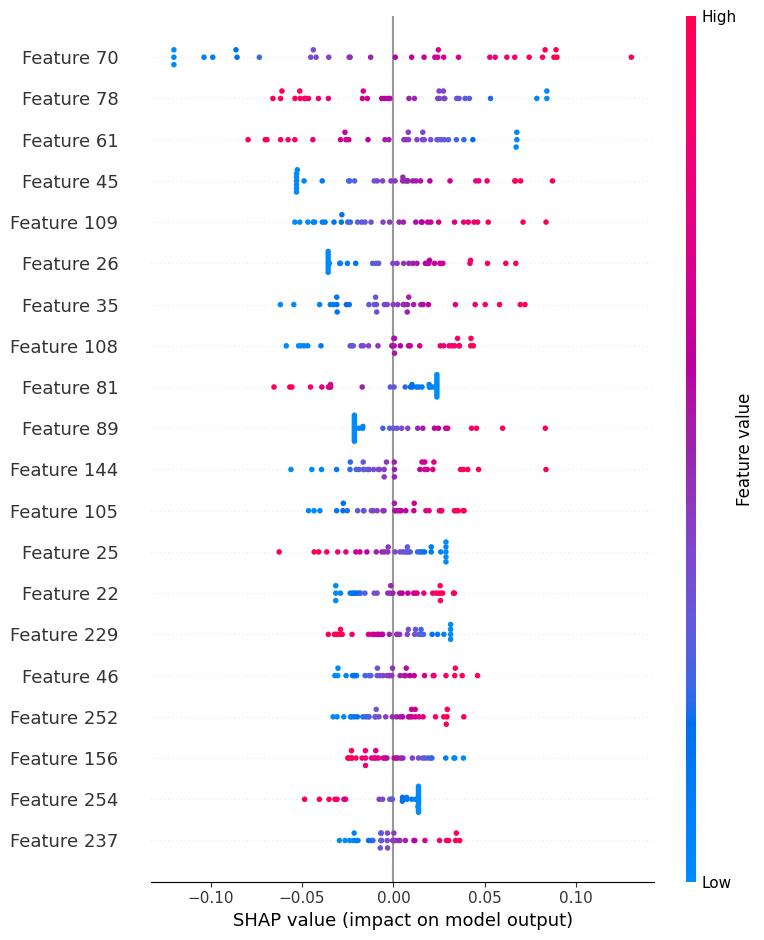

In [ ]:
# SHAP explanation for the best model
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)